In [1]:
#import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt

def filter_scores(scores):
    return [score for score in scores if type(score)==np.ndarray and score.tolist()!=[]]

def get_filter_indices(scores):
    return [i for i,score in enumerate(scores) if type(score)==np.ndarray and score.tolist()!=[]]

improvement_models = ['gpt-3.5-turbo','gpt-4o-mini-2024-07-18']
model_names = {'gpt-4o-mini-2024-07-18':'GPT-4o-mini', 'gpt-3.5-turbo':'GPT-3.5-Turbo'}
names_methods = {'weak':'Naive FT', 'icl_improved':'ICL (ours)', 'improved':'IaR (ours)'} #, 

Bias

In [239]:
experiment = 'bias'
scores = np.load(f'outputs/scores_benchmarks_{experiment}.npy', allow_pickle=True).item()
answers = np.load(f'outputs/answers_benchmarks_{experiment}.npy', allow_pickle=True).item()

In [259]:
for eval in ['content','style']:
    print(eval)
    ind = {'content':0,'style':1}[eval]
    task = f'bias_{eval}'
    print(np.mean(scores[task]['naive_gpt_gpt-3.5-turbo'],0)[ind], np.mean(scores[task]['naive_gpt_gpt-4o-mini-2024-07-18'],0)[ind])
    print(np.mean(scores[task]['weak_gpt_gpt-3.5-turbo']['weak'],0)[ind], np.mean(scores[task]['weak_gpt_gpt-4o-mini-2024-07-18']['weak'],0)[ind])
    print(np.mean(scores[task]['weak_gpt_gpt-3.5-turbo']['improved'],0)[ind], np.mean(scores[task]['weak_gpt_gpt-4o-mini-2024-07-18']['improved'],0)[ind])

content
8.973076923076926 8.765384615384615
7.803846153846154 6.815384615384615
9.030769230769229 8.778846153846155
style
0.7134615384615385 0.9230769230769231
1.0 1.0
0.9634615384615385 0.9807692307692307


Persona/Simple

In [17]:
experiment = 'persona'
scores = np.load(f'outputs/scores_benchmarks_{experiment}.npy', allow_pickle=True).item()
answers = np.load(f'outputs/answers_benchmarks_{experiment}.npy', allow_pickle=True).item()

99


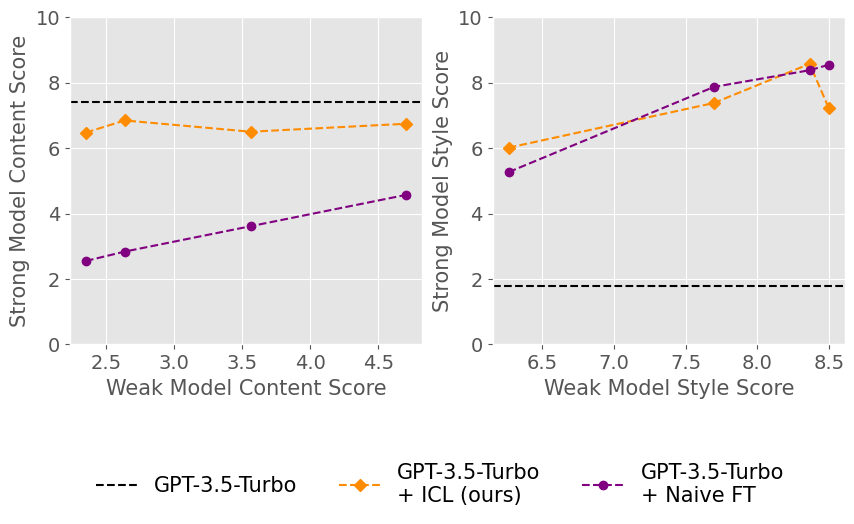

100


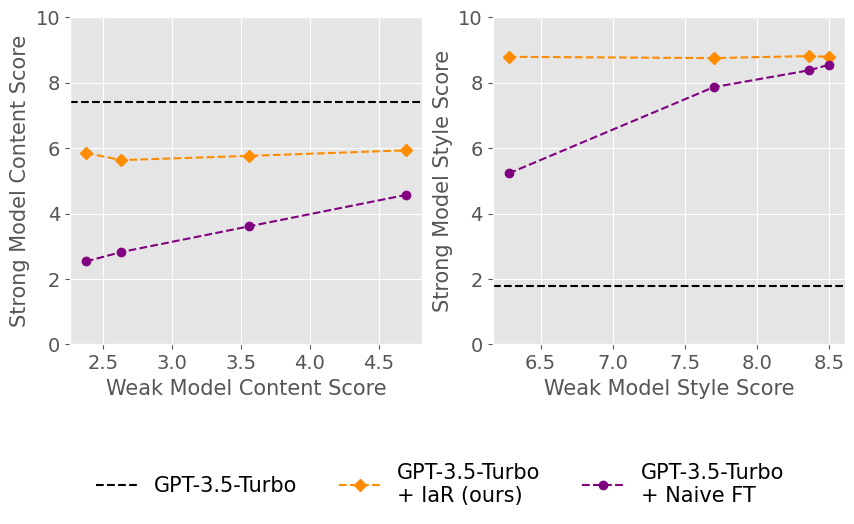

100


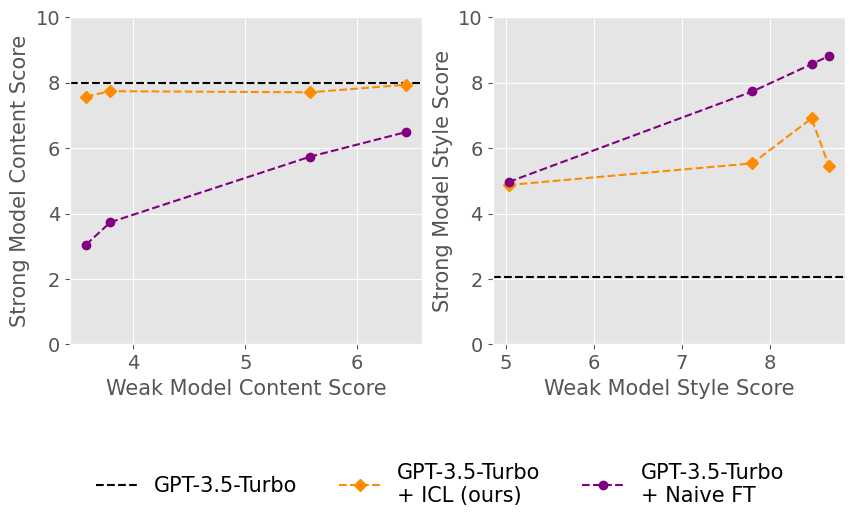

100


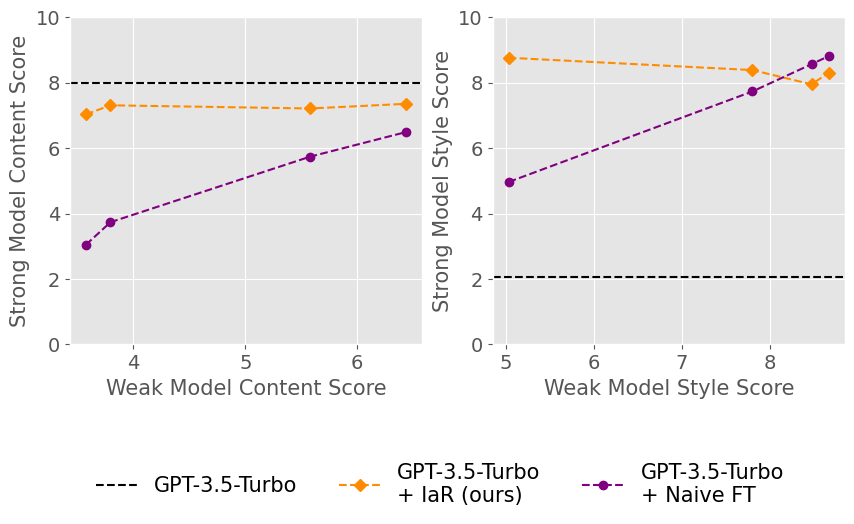

91


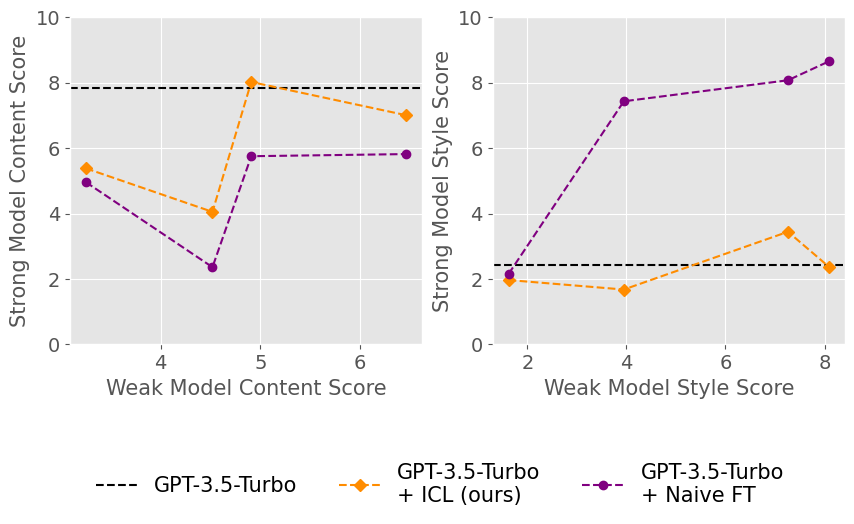

91


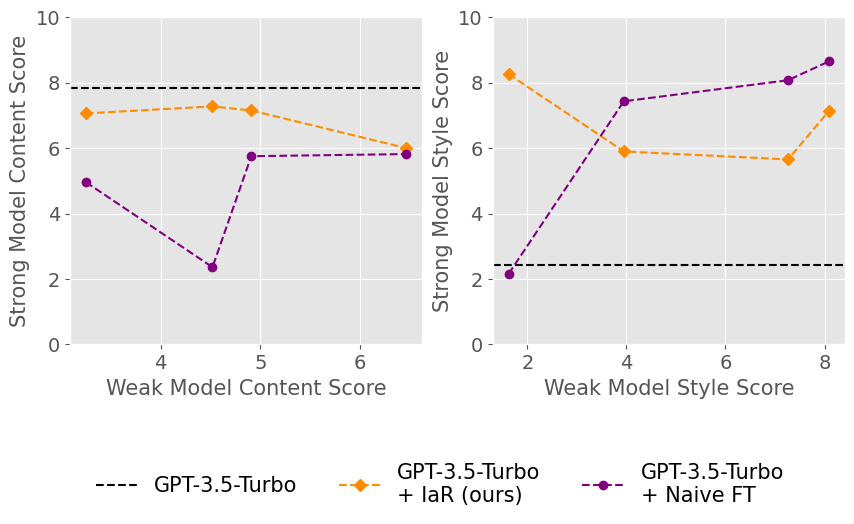

100


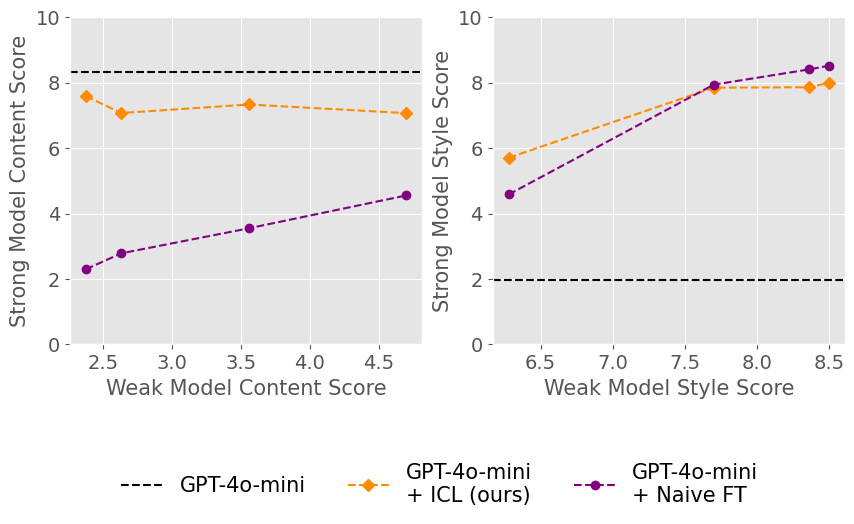

100


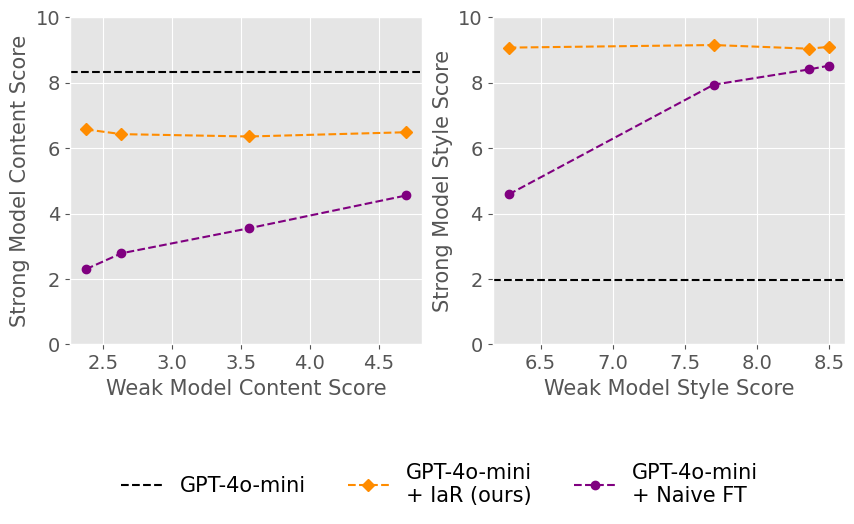

99


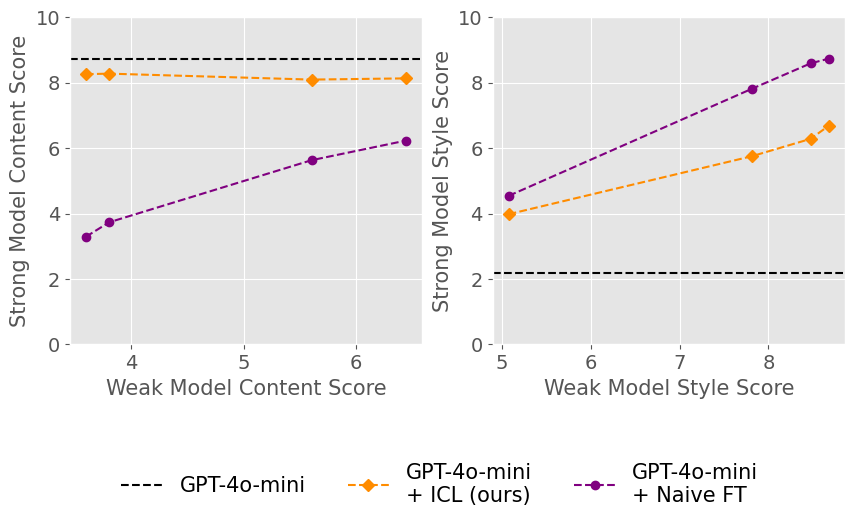

99


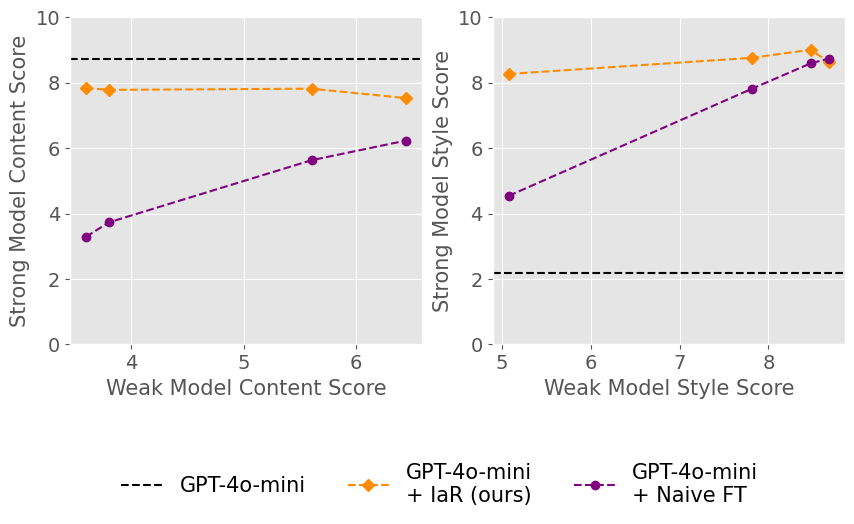

92


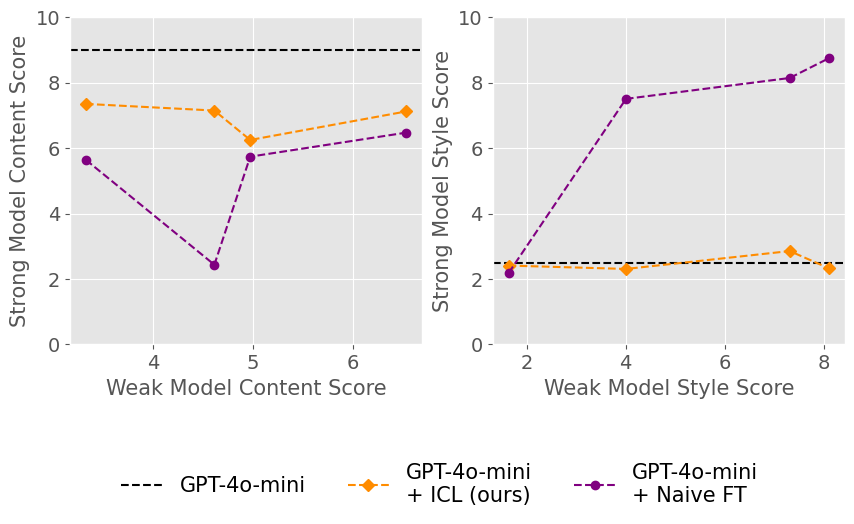

92


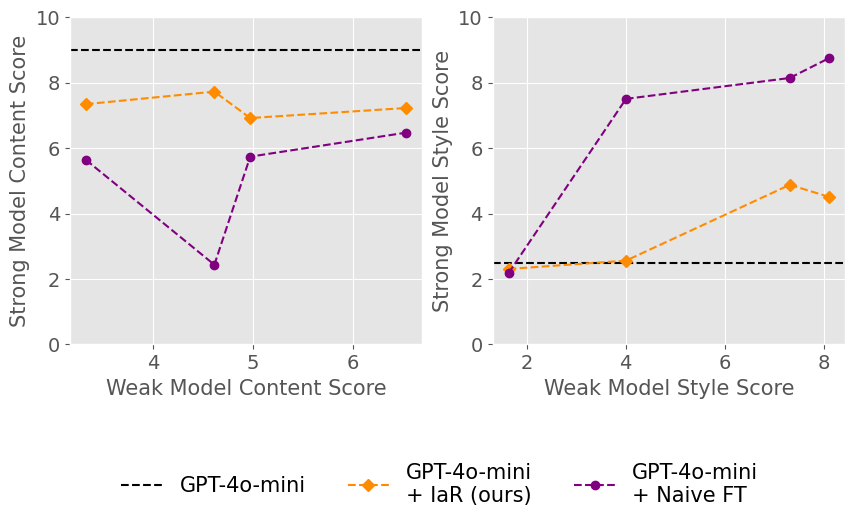

In [18]:
weak_models = ['falcon','llama2','mistral','gemma']
dim_names = ['Content','Style']

plt.rcParams.update({'font.size': 19})
plt.style.use('ggplot')

for improvement_model in improvement_models:
    for bench in scores.keys():
        for i,methods in enumerate([['icl_improved','weak'], ['improved','weak']]):
        
            naive_gpt_list = [get_filter_indices(scores[bench]['naive_gpt_'+improvement_model]) for weak_model in weak_models]
            weak_models_list = [get_filter_indices(scores[bench][weak_model]) for weak_model in weak_models]
            improved_list = []
            for method in methods: improved_list += [get_filter_indices(scores[bench][weak_model+"_"+improvement_model][method]) for weak_model in weak_models]
            lists = naive_gpt_list+weak_models_list+improved_list
            intersection = list(set(lists[0]).intersection(*lists[1:]))
            print(len(intersection))
            
            fig, axes = plt.subplots(1, 2, figsize=(10, 4.25))  # Create 1 row and 2 columns of subplots
            
            for dim, ax in enumerate(axes):
                baseline = np.array(np.mean([scores[bench]['naive_gpt_'+improvement_model][i] for i in intersection], 0)[dim])
                weak = np.array([np.mean([scores[bench][weak_model][i] for i in intersection], 0)[dim] for weak_model in weak_models])
                fine_tuned = np.array([[np.mean([scores[bench][weak_model+"_"+improvement_model][method][i] for i in intersection], 0)[dim] for weak_model in weak_models] for method in methods])
                
                baseline_std = np.array(np.std([scores[bench]['naive_gpt_'+improvement_model][i] for i in intersection], 0)[dim]) / np.sqrt(len(intersection))
                weak_std = np.array([np.std([scores[bench][weak_model][i] for i in intersection], 0)[dim] for weak_model in weak_models]) / np.sqrt(len(intersection))
                fine_tuned_std = np.array([[np.std([scores[bench][weak_model+"_"+improvement_model][method][i] for i in intersection], 0)[dim] for weak_model in weak_models] for method in methods])/np.sqrt(len(intersection))
                
                order = np.argsort(weak)
                x = weak[order]
                y_wft = fine_tuned[1][order]
                y_icl = fine_tuned[0][order]
                s_wft = fine_tuned_std[1][order]
                s_icl = fine_tuned_std[0][order]
        
                ax.axhline(y= baseline, linestyle='dashed', color = 'black', label = model_names[improvement_model])
                ax.plot(x, y_icl, label = f'{model_names[improvement_model]}\n+ {names_methods[methods[0]]}', linestyle = 'dashed', marker='D', color = 'darkorange')
                #ax.fill_between(x, y1= y_icl - s_icl, y2=y_icl + s_icl, alpha=0.1, color = 'darkorange')
                ax.plot(x, y_wft, label = f'{model_names[improvement_model]}\n+ {names_methods[methods[1]]}', linestyle = 'dashed', marker='o', color = 'purple')
                #ax.fill_between(x, y1= y_wft - s_wft, y2= y_wft + s_wft, alpha=0.1, color = 'purple')
                
                ax.set_xlabel(f'Weak Model {dim_names[dim]} Score', fontsize=15)
                ax.set_ylabel(f'Strong Model {dim_names[dim]} Score', fontsize=15)
                #ax.set_title(f'{dim_names[dim]} on {bench}')
                if dim==0: ax.legend(prop={'size':15}, loc='lower center', ncols=3, framealpha=0,bbox_to_anchor=(1.05, -.55)) #
                ax.set_ylim(0, 10)
                ax.tick_params(axis='both', which='major', labelsize=14)

            plt.savefig(f'plots/bench-{bench}_model-{improvement_model}_method-{i}.pdf', bbox_inches='tight', dpi=400, transparent=False)
            plt.show()